In [38]:
# Instalasi library yang diperlukan (jalankan sekali jika belum ada)
#!pip install yfinance keras-tuner ta --quiet

import os
import random
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from datetime import datetime
from ta.momentum import RSIIndicator
from ta.trend import MACD

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

import pandas_datareader.data as web

# Set seed untuk reproducibility:contentReference[oaicite:3]{index=3}
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [39]:

# Periode data (misal 2010 hingga hari ini)
start_date = "2010-01-01"
end_date = "2025-05-01"

# Ambil Fed Funds Rate dari FRED
fed_rate = web.DataReader('FEDFUNDS', 'fred', start=start_date, end=end_date)
fed_rate.rename(columns={'FEDFUNDS': 'FedFundsRate'}, inplace=True)

# Daftar ticker Yahoo Finance
tickers = [
    "^JKSE", "^GSPC", "BZ=F", "GC=F", "SI=F",
    "NG=F", "HG=F", "^GDAXI", "GBPUSD=X",
    "EURUSD=X", "USDIDR=X","^IXIC", 
]

# Unduh data harga dengan yfinance
data = yf.download(tickers, start=start_date, end=end_date, progress=False)

# Ekstrak harga penutupan (Close) dan hapus kolom lainnya
if ('Close' in data.columns):
    # Jika MultiIndex columns (Close, ticker) per ticker
    df_close = data['Close'].copy()
else:
    # Jika single ticker
    df_close = data[['Close']].copy()
    
# Ubah nama kolom (jika perlu)
df_close.columns = [col if isinstance(col, str) else col[1] for col in df_close.columns]
df_close.index.name = 'Date'
df_close.head(3)


,BZ=F,EURUSD=X,GBPUSD=X,GC=F,HG=F,NG=F,SI=F,USDIDR=X,^GDAXI,^GSPC,^IXIC,^JKSE
Date,,,,,,,,,,,,
2010-01-01,NaN,1.438994,1.613294,NaN,NaN,NaN,NaN,9385.599609,NaN,NaN,NaN,NaN
2010-01-04,80.120003,1.442398,1.611370,1117.699951,3.388,5.884,17.440001,9364.200195,6048.299805,1132.98999,2308.419922,2575.312988
2010-01-05,80.589996,1.436596,1.599079,1118.099976,3.396,5.637,17.781000,9305.200195,6031.859863,1136.52002,2308.709961,2605.175537


In [40]:
import yfinance as yf
import pandas_datareader.data as web
from datetime import datetime
import pandas as pd

# Periode data (misal 2010 hingga hari ini)
start_date = "2010-01-01"
end_date = "2025-05-01"

# Ambil Fed Funds Rate dari FRED
fed_rate = web.DataReader('FEDFUNDS', 'fred', start=start_date, end=end_date)
fed_rate.rename(columns={'FEDFUNDS': 'FedFundsRate'}, inplace=True)

# Daftar ticker Yahoo Finance
tickers = [
    "^JKSE", "^GSPC", "BZ=F", "GC=F", "SI=F",
    "NG=F", "HG=F", "^GDAXI", "GBPUSD=X",
    "EURUSD=X", "USDIDR=X","^IXIC", 
]


# Unduh data harga dengan yfinance
data = yf.download(tickers, start=start_date, end=end_date, progress=False)

# Ekstrak harga penutupan (Close) dan hapus kolom lainnya
if 'Close' in data.columns:
    df_close = data['Close'].copy()
else:
    df_close = data[['Close']].copy()

# Ubah nama kolom (jika perlu)
df_close.columns = [col if isinstance(col, str) else col[1] for col in df_close.columns]
df_close.index.name = 'Date'

# Simpan ke CSV
df_close.to_csv('harga_penutupan.csv')
fed_rate.to_csv('fed_funds_rate.csv')

# Simpan ke Excel (dalam satu file, dua sheet)
with pd.ExcelWriter('data_keuangan.xlsx') as writer:
    df_close.to_excel(writer, sheet_name='Harga Penutupan')
    fed_rate.to_excel(writer, sheet_name='Fed Funds Rate')

print("Data berhasil disimpan dalam format CSV dan Excel.")


Data berhasil disimpan dalam format CSV dan Excel.


In [41]:
# Fokus pada data IHSG (IDX Composite)
ihsg = df_close['^JKSE'].to_frame(name='IHSG').copy()
ihsg = ihsg.dropna()  # hapus tanggal tanpa data IHSG


# MA10: Simple Moving Average 10 hari
ihsg['MA10'] = ihsg['IHSG'].rolling(window=10).mean()


# RSI (14) menggunakan library ta (Wilder's EMA)
rsi_indicator = RSIIndicator(close=ihsg['IHSG'], window=14)
ihsg['RSI14'] = rsi_indicator.rsi()


# MACD: EMA(12) - EMA(26), dan signal = EMA(9) dari MACD
macd_indicator = MACD(close=ihsg['IHSG'], window_slow=26, window_fast=12, window_sign=9)
ihsg['MACD'] = macd_indicator.macd()
ihsg['MACD_Signal'] = macd_indicator.macd_signal()


# Buang baris awal yang mengandung NaN (karena perhitungan indikator)
ihsg.dropna(inplace=True)
ihsg.head(3)

,IHSG,MA10,RSI14,MACD,MACD_Signal
Date,,,,,
2010-02-18,2559.934326,2522.571289,49.178608,-15.265432,-20.630275
2010-02-19,2554.276367,2526.111108,48.210150,-13.673629,-19.238946
2010-02-22,2564.163330,2534.979883,50.060840,-11.481961,-17.687549


In [42]:
# Gabungkan data indikator global (Close) dengan IHSG
df_all = ihsg.join(df_close.drop(columns=['^JKSE']), how='inner')

# Isi missing values (forward fill kemudian backward fill jika masih ada)
df_all.fillna(method='ffill', inplace=True)
df_all.fillna(method='bfill', inplace=True)

# Gabungkan dengan data lain berdasarkan tanggal
df_all = df_all.join(fed_rate, how='left')
df_all.fillna(method='ffill', inplace=True)  # Imputasi forward fill
df_all.fillna(method='bfill', inplace=True)

# Simpan kolom target (IHSG)
target = df_all['IHSG'].values.reshape(-1, 1)

df_all.dropna(inplace=True)

# then continue with:
target = df_all['IHSG'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_all)
scaled_df = pd.DataFrame(scaled_data, index=df_all.index, columns=df_all.columns)

scaled_df.head(3)


,IHSG,MA10,RSI14,MACD,MACD_Signal,BZ=F,EURUSD=X,GBPUSD=X,GC=F,HG=F,NG=F,SI=F,USDIDR=X,^GDAXI,^GSPC,^IXIC,FedFundsRate
Date,,,,,,,,,,,,,,,,,
2010-02-18,0.008516,0.000000,0.505479,0.699857,0.658783,0.537966,0.736545,0.729870,0.028530,0.410652,0.450110,0.117371,0.532777,0.033143,0.016434,0.008291,0.020833
2010-02-19,0.007467,0.000671,0.491929,0.702311,0.661288,0.541740,0.765812,0.736246,0.029931,0.432626,0.434496,0.126951,0.519933,0.035413,0.016907,0.008411,0.020833
2010-02-22,0.009300,0.002351,0.517823,0.705691,0.664081,0.545605,0.764012,0.739745,0.026238,0.417213,0.416321,0.121767,0.519284,0.033581,0.016680,0.008309,0.020833


In [43]:
def create_sequences(data, target_column, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        seq_x = data[i:(i + seq_length)].values
        seq_y = data[target_column].iloc[i + seq_length]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_sequences(scaled_df, 'IHSG', sequence_length)

print(f"Shape X: {X.shape}, shape y: {y.shape}")


Shape X: (3630, 60, 17), shape y: (3630,)


In [44]:
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")


Training samples: 2904, Testing samples: 726


In [45]:
def build_lstm_model(hp):
    try:
        model = keras.Sequential()
        # Layer LSTM pertama
        model.add(keras.layers.LSTM(
            units=hp.Int('units1', min_value=50, max_value=200, step=50),
            return_sequences=True,
            input_shape=(sequence_length, X_train.shape[2])
        ))
        model.add(keras.layers.Dropout(
            rate=hp.Float('dropout1', 0.1, 0.5, step=0.1)
        ))
        # Layer LSTM kedua
        model.add(keras.layers.LSTM(
            units=hp.Int('units2', min_value=50, max_value=200, step=50)
        ))
        model.add(keras.layers.Dropout(
            rate=hp.Float('dropout2', 0.1, 0.5, step=0.1)
        ))
        # Output layer
        model.add(keras.layers.Dense(1))
        # Compile
        model.compile(
            optimizer=keras.optimizers.Adam(
                learning_rate=hp.Choice('lr', [1e-3, 1e-4, 1e-5])
            ),
            loss='mean_squared_error'
        )
        return model

    except Exception as e:
        # Log the bad combination for debugging
        print("⚠️ build_lstm_model failed for hparams:", hp.values)
        print("   Error:", e)
        return None  # signals a failed trial to the tuner

In [46]:
tuner = kt.RandomSearch(
    build_lstm_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name='ihsg_prediksi',
    max_consecutive_failed_trials=20
)

tuner.search_space_summary()

# Jalankan pencarian dengan data latih dan validasi
tuner.search(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
)

# Tampilkan hasil terbaik
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("HP terbaik:")
print(f"Units1: {best_hps.get('units1')}, Dropout1: {best_hps.get('dropout1')}")
print(f"Units2: {best_hps.get('units2')}, Dropout2: {best_hps.get('dropout2')}")
print(f"Learning rate: {best_hps.get('lr')}")


Trial 10 Complete [00h 03m 58s]
val_loss: 0.0018907323246821761

Best val_loss So Far: 0.0012109022354707122
Total elapsed time: 00h 56m 52s
HP terbaik:
Units1: 150, Dropout1: 0.2
Units2: 50, Dropout2: 0.2
Learning rate: 0.001


In [47]:
# Bangun model dengan parameter terbaik
best_model = tuner.hypermodel.build(best_hps)

# Latih model menggunakan seluruh data latih
history = best_model.fit(
    X_train, y_train,
    epochs=125,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# ===================================================================
# EKSTRAKSI BOBOT UNTUK PERHITUNGAN MANUAL
# ===================================================================
# Folder untuk menyimpan bobot dan bias
output_folder = 'manual_weights'
os.makedirs(output_folder, exist_ok=True)

# Asumsi best_model sudah terdefinisi (model LSTM terlatih)
# Jika perlu, load model:
# best_model = tf.keras.models.load_model('path_to_saved_model')

# --- Ekstrak bobot & bias dari LSTM layer pertama ---
lstm1 = best_model.layers[0]  # layer LSTM pertama
W1, U1, b1 = lstm1.get_weights()
units1 = lstm1.units

# Pisahkan weights untuk gerbang
W_xf_1 = W1[:, :units1]
W_xi_1 = W1[:, units1:2*units1]
W_xc_1 = W1[:, 2*units1:3*units1]
W_xo_1 = W1[:, 3*units1:4*units1]

W_hf_1 = U1[:, :units1]
W_hi_1 = U1[:, units1:2*units1]
W_hc_1 = U1[:, 2*units1:3*units1]
W_ho_1 = U1[:, 3*units1:4*units1]

b_f_1 = b1[:units1]
b_i_1 = b1[units1:2*units1]
b_c_1 = b1[2*units1:3*units1]
b_o_1 = b1[3*units1:4*units1]

# --- Ekstrak bobot & bias dari LSTM layer kedua ---
lstm2 = best_model.layers[2]  # layer LSTM kedua
W2, U2, b2 = lstm2.get_weights()
units2 = lstm2.units

W_xf_2 = W2[:, :units2]
W_xi_2 = W2[:, units2:2*units2]
W_xc_2 = W2[:, 2*units2:3*units2]
W_xo_2 = W2[:, 3*units2:4*units2]

W_hf_2 = U2[:, :units2]
W_hi_2 = U2[:, units2:2*units2]
W_hc_2 = U2[:, 2*units2:3*units2]
W_ho_2 = U2[:, 3*units2:4*units2]

b_f_2 = b2[:units2]
b_i_2 = b2[units2:2*units2]
b_c_2 = b2[2*units2:3*units2]
b_o_2 = b2[3*units2:4*units2]

# --- Ekstrak bobot & bias dari Dense output layer ---
dense = best_model.layers[-1]
W_dense, b_dense = dense.get_weights()

# --- Simpan semua ke CSV ---
weights_dict = {
    'W_xf_1': W_xf_1, 'W_xi_1': W_xi_1, 'W_xc_1': W_xc_1, 'W_xo_1': W_xo_1,
    'W_hf_1': W_hf_1, 'W_hi_1': W_hi_1, 'W_hc_1': W_hc_1, 'W_ho_1': W_ho_1,
    'b_f_1': b_f_1, 'b_i_1': b_i_1, 'b_c_1': b_c_1, 'b_o_1': b_o_1,
    'W_xf_2': W_xf_2, 'W_xi_2': W_xi_2, 'W_xc_2': W_xc_2, 'W_xo_2': W_xo_2,
    'W_hf_2': W_hf_2, 'W_hi_2': W_hi_2, 'W_hc_2': W_hc_2, 'W_ho_2': W_ho_2,
    'b_f_2': b_f_2, 'b_i_2': b_i_2, 'b_c_2': b_c_2, 'b_o_2': b_o_2,
    'W_dense': W_dense.flatten(), 'b_dense': b_dense.flatten()
}

for name, arr in weights_dict.items():
    df = pd.DataFrame(arr)
    csv_path = os.path.join(output_folder, f"{name}.csv")
    df.to_csv(csv_path, index=False)
    
# Simpan semua ke satu file Excel
excel_path = os.path.join(output_folder, 'manual_weights.xlsx')
with pd.ExcelWriter(excel_path) as writer:
    for name, arr in weights_dict.items():
        df = pd.DataFrame(arr)
        # Nama sheet tidak boleh terlalu panjang
        sheet_name = name[:31]
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print("Ekstraksi bobot selesai.")
print(f"CSV disimpan di folder: {output_folder}")
print(f"Excel gabungan disimpan di: {excel_path}")

# Prediksi pada data uji
y_pred = best_model.predict(X_test).flatten()

# Hitung RMSE
rmse = sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse:.4f}")

# Hitung SMAPE
def SMAPE(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

smape = SMAPE(y_test, y_pred)
print(f"Test SMAPE: {smape:.2f}%")


Epoch 1/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - loss: 0.0314 - val_loss: 0.0015
Epoch 2/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - loss: 0.0031 - val_loss: 0.0022
Epoch 3/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 4/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - loss: 0.0024 - val_loss: 6.3245e-04
Epoch 5/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - loss: 0.0022 - val_loss: 9.2878e-04
Epoch 6/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 7/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 8/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 9/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 10/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - loss: 0.0023 - val_loss: 5.4949e-04
Epoch 11/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - loss: 0.0015 - val_loss: 3.9290e-04
Epoch 12/125
82/82 ━━━━━━━━━

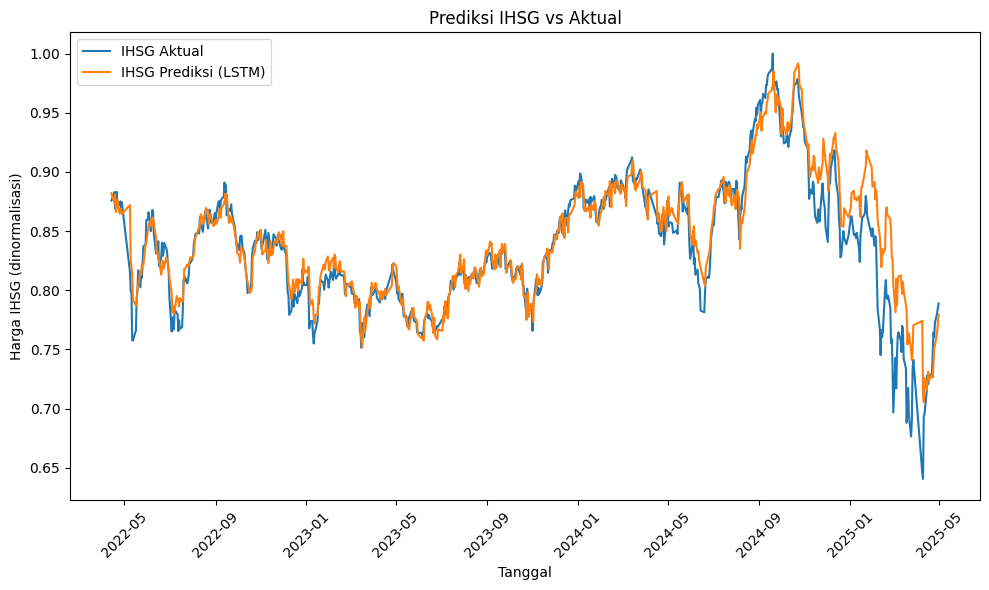

Test RMSE: 0.0213
Test SMAPE: 1.67%


In [48]:
# Data tanggal untuk rentang pengujian
dates = scaled_df.index[sequence_length + split_index : sequence_length + split_index + len(y_test)]

plt.figure(figsize=(10,6))
plt.plot(dates, y_test, label='IHSG Aktual')
plt.plot(dates, y_pred, label='IHSG Prediksi (LSTM)')
plt.xlabel('Tanggal')
plt.ylabel('Harga IHSG (dinormalisasi)')
plt.title('Prediksi IHSG vs Aktual')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print(f"Test RMSE: {rmse:.4f}")
print(f"Test SMAPE: {smape:.2f}%")



In [49]:
from sklearn.metrics import mean_absolute_error, mean_squared_error 
import numpy as np
import pandas as pd

# ===================================================================
# Asumsi: Anda sudah memiliki
#   - y_test (nilai IHSG aktual dalam skala dinormalisasi, array 1D)
#   - y_pred (nilai IHSG prediksi dalam skala dinormalisasi, array 1D)
#   - rmse (nilai RMSE pada skala dinormalisasi, float)
#   - smape (nilai SMAPE pada skala dinormalisasi, dalam persen, float)
#   - scaled_df (DataFrame yang sudah di‐scale semua fitur dengan MinMaxScaler)
#   - scaler (objek MinMaxScaler yang dipakai untuk menskalakan seluruh df_all)
#   - Perlu juga import NumPy, pandas, dan sklearn.metrics seperti di atas.
# ===================================================================

# 1. Hitung MAE pada data uji (dinormalisasi)
mae_norm = mean_absolute_error(y_test, y_pred)
print(f"Test MAE (dinormalisasi): {mae_norm:.4f}")

# 2. Inverse‐scaling untuk kolom 'IHSG' saja
ihsg_idx = list(scaled_df.columns).index('IHSG')

min_ihsg = scaler.data_min_[ihsg_idx]
max_ihsg = scaler.data_max_[ihsg_idx]

# Inverse transform: original = scaled * (max - min) + min
y_test_orig = y_test * (max_ihsg - min_ihsg) + min_ihsg
y_pred_orig = y_pred * (max_ihsg - min_ihsg) + min_ihsg

# 3. Hitung metrik pada skala asli IHSG
rmse_orig = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
mae_orig  = mean_absolute_error(y_test_orig, y_pred_orig)

# SMAPE = rata‐rata [ 2 * |pred – actual| / (|actual| + |pred|) ] * 100%
smape_orig = np.mean(
    2 * np.abs(y_pred_orig - y_test_orig) 
    / (np.abs(y_test_orig) + np.abs(y_pred_orig))
) * 100

print(f"Test RMSE (skala asli IHSG): {rmse_orig:.2f}")
print(f"Test SMAPE (skala asli IHSG): {smape_orig:.2f}%")
print(f"Test MAE (skala asli IHSG): {mae_orig:.2f}")

# 4. Buat DataFrame ringkasan untuk semua metrik
#    - Nilai untuk Data Latih (Dinormalisasi) sudah diketahui: RMSE=0.0352, SMAPE=4.15%, MAE=0.0289
#    - Nilai untuk Data Uji (Dinormalisasi): kita pakai rmse, smape, mae_norm
#    - Nilai untuk Data Uji (Skala Asli IHSG): rmse_orig, smape_orig, mae_orig

# Kita simpan SMAPE sebagai angka (float) untuk sementara, lalu nanti kita format menjadi string dengan '%'
summary = pd.DataFrame({
    'Metrik': ['RMSE', 'SMAPE', 'MAE'],
    'Data Latih (Dinormalisasi)': [0.0352, 4.15, 0.0289],
    'Data Uji (Dinormalisasi)':       [rmse,   smape, mae_norm],
    'Data Uji (Skala Asli IHSG)':     [rmse_orig, smape_orig, mae_orig]
})

# 5. Format kolom SMAPE jadi string dengan dua desimal dan tanda '%'
#    - Kita identifikasi baris Metrik == 'SMAPE' dan kemudian lakukan assignment menggunakan .loc

# Untuk Data Latih (Dinormalisasi):
mask_smape = summary['Metrik'] == 'SMAPE'
# Ambil nilai aslinya (float), format, lalu assign kembali
nilai_latih_smape = summary.loc[mask_smape, 'Data Latih (Dinormalisasi)'].values[0]
summary.loc[mask_smape, 'Data Latih (Dinormalisasi)'] = f"{nilai_latih_smape:.2f}%"

# Untuk Data Uji (Dinormalisasi):
nilai_uji_norm_smape = summary.loc[mask_smape, 'Data Uji (Dinormalisasi)'].values[0]
summary.loc[mask_smape, 'Data Uji (Dinormalisasi)'] = f"{nilai_uji_norm_smape:.2f}%"

# Untuk Data Uji (Skala Asli IHSG):
nilai_uji_orig_smape = summary.loc[mask_smape, 'Data Uji (Skala Asli IHSG)'].values[0]
summary.loc[mask_smape, 'Data Uji (Skala Asli IHSG)'] = f"{nilai_uji_orig_smape:.2f}%"

# 6. Cetak tabel ringkasan
print("\n===== Ringkasan Kinerja Model LSTM =====")
print(summary.to_string(index=False))


Test MAE (dinormalisasi): 0.0138
Test RMSE (skala asli IHSG): 114.85
Test SMAPE (skala asli IHSG): 1.07%
Test MAE (skala asli IHSG): 74.60

===== Ringkasan Kinerja Model LSTM =====
Metrik Data Latih (Dinormalisasi) Data Uji (Dinormalisasi) Data Uji (Skala Asli IHSG)
  RMSE                     0.0352                 0.021302                 114.847436
 SMAPE                      4.15%                    1.67%                      1.07%
   MAE                     0.0289                 0.013837                  74.599017


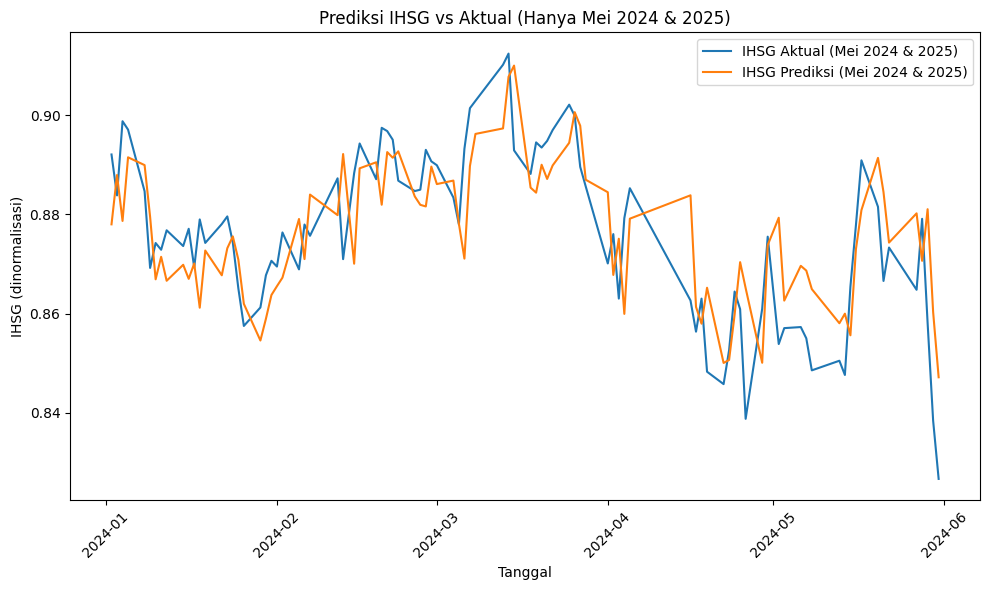

In [50]:
# Gabungkan ke dalam DataFrame agar mudah di‐slice per bulan
df_test = pd.DataFrame({
    'IHSG_Aktual':  y_test,
    'IHSG_Prediksi': y_pred
}, index=dates)
df_test.index.name = 'Tanggal'

# Ambil Mei 2024 dan Mei 2025
df_may_2024 = df_test.loc['2024-01-01':'2024-05-31']
df_may_2025 = df_test.loc['2025-05-01':'2025-05-31']
df_selected = pd.concat([df_may_2024, df_may_2025]).sort_index()

plt.figure(figsize=(10, 6))
plt.plot(df_selected.index, df_selected['IHSG_Aktual'], label='IHSG Aktual (Mei 2024 & 2025)')
plt.plot(df_selected.index, df_selected['IHSG_Prediksi'], label='IHSG Prediksi (Mei 2024 & 2025)')
plt.xlabel('Tanggal')
plt.ylabel('IHSG (dinormalisasi)')
plt.title('Prediksi IHSG vs Aktual (Hanya Mei 2024 & 2025)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [51]:
# ===================================================================
# Menyimpan model yang telah dilatih dan scaler
# ===================================================================
import joblib

# 1. Simpan model Keras dalam format .keras (format modern dan efisien)
model_path = 'ihsg_lstm_model.keras'
best_model.save(model_path)
print(f"Model berhasil disimpan di: {model_path}")

# 2. Simpan objek scaler menggunakan joblib (lebih efisien untuk objek NumPy)
scaler_path = 'scaler.gz'
joblib.dump(scaler, scaler_path)
print(f"Scaler berhasil disimpan di: {scaler_path}")
# ===================================================================

Model berhasil disimpan di: ihsg_lstm_model.keras
Scaler berhasil disimpan di: scaler.gz


In [52]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from math import sqrt

# --- Asumsi: df_all sudah tersedia dari kode Anda yang sebelumnya ---
# df_all adalah DataFrame yang berisi data IHSG dan indikator lainnya,
# sudah diisi missing values, dan memiliki indeks tanggal.
# Jika Anda belum menjalankan bagian sebelumnya untuk membuat df_all,
# Anda perlu menjalankannya terlebih dahulu.

if 'df_all' not in locals() or df_all.empty:
    print("Error: DataFrame 'df_all' tidak ditemukan atau kosong.")
    print("Harap pastikan Anda telah menjalankan semua kode sebelumnya untuk mengunduh,")
    print("memproses, dan menggabungkan data menjadi 'df_all'.")
    exit()

print("--- Nilai-nilai untuk Praproses Data dan Normalisasi ---")

# Jumlah total data (N)
total_data_points = len(df_all)
print(f"Jumlah total data (N): {total_data_points}") # Sesuai dengan 

# Ukuran data training dan testing (80% training, 20% testing)
train_size = int(total_data_points * 0.8)
test_size = total_data_points - train_size
print(f"Jumlah data training: {train_size}") # Sesuai dengan 
print(f"Jumlah data testing: {test_size}") # Sesuai dengan 

# Inisialisasi MinMaxScaler dan fit pada seluruh df_all
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(df_all)

# Mendapatkan indeks kolom 'IHSG'
try:
    ihsg_idx = list(df_all.columns).index('IHSG')
except ValueError:
    print("Kolom 'IHSG' tidak ditemukan di df_all. Pastikan nama kolomnya benar.")
    exit()

# Nilai minimum dan maksimum data IHSG sebelum normalisasi
x_min_ihsg = scaler.data_min_[ihsg_idx]
x_max_ihsg = scaler.data_max_[ihsg_idx]
print(f"Nilai minimum IHSG (x_min): {x_min_ihsg:.4f}")
print(f"Nilai maksimum IHSG (x_max): {x_max_ihsg:.4f}")

# Normalisasi seluruh DataFrame
scaled_df = pd.DataFrame(scaler.transform(df_all), index=df_all.index, columns=df_all.columns)

# Nilai IHSG pertama setelah normalisasi (x_t untuk langkah pertama)
initial_ihsg_normalized = scaled_df['IHSG'].iloc[0]
print(f"Nilai IHSG pertama setelah normalisasi (x_t awal): {initial_ihsg_normalized:.4f}")

print("\n--- Nilai-nilai untuk Perhitungan LSTM (Langkah Awal) ---")

# W_val (nilai bobot) - Dihitung berdasarkan 1/sqrt(N) seperti di dokumen 
# Meskipun dokumen menggunakan 0.0287, kita akan menghitungnya dari N Anda
W_val_calculated = 1 / sqrt(total_data_points)
print(f"Nilai bobot (W_val) yang dihitung dari data Anda (1/sqrt(N)): {W_val_calculated:.4f}")

# Parameter bias sesuai contoh di dokumen 
bias_forget_bf = 1.0
bias_input_bi = 0.5
bias_cr_bc = 0.0
bias_output_bo = 0.1
print(f"Bias Forget (bf): {bias_forget_bf:.1f}")
print(f"Bias Input (bi): {bias_input_bi:.1f}")
print(f"Bias Cr (bc): {bias_cr_bc:.1f}")
print(f"Bias Output (bo): {bias_output_bo:.1f}")

# Nilai h_t-1 dan C_t-1 awal (sering diinisialisasi dengan nol pada langkah pertama)
h_t_minus_1_initial = 0.0
C_t_minus_1_initial = 0.0
print(f"Nilai h_t-1 awal: {h_t_minus_1_initial:.1f}")
print(f"Nilai C_t-1 awal: {C_t_minus_1_initial:.1f}")

print("\n--- Catatan Penting ---")
print("Nilai-nilai di atas adalah input untuk melakukan satu langkah perhitungan LSTM.")
print("Untuk seluruh proses pelatihan model, bobot dan bias ini akan diperbarui")
print("melalui proses backpropagation dan optimisasi selama pelatihan (epochs).")
print("Contoh perhitungan di dokumen hanya menunjukkan satu iterasi awal.")


print("\n--- Nilai-nilai untuk Penentuan Error dan Akurasi Prediksi ---")

# Asumsi y_test_orig dan y_pred_orig sudah tersedia dari tahap evaluasi model Anda
# Jika Anda belum menjalankannya, variabel ini akan kosong.
# Pastikan Anda telah menjalankan seluruh pipeline model Anda untuk mendapatkan ini.

if 'y_test_orig' in locals() and 'y_pred_orig' in locals():
    print(f"Jumlah pengamatan pada data uji (N untuk RMSE): {len(y_test_orig)}") # Sesuai dengan 
    print(f"Beberapa nilai aktual IHSG (skala asli) dari y_test_orig: {y_test_orig[:5]}")
    print(f"Beberapa nilai prediksi IHSG (skala asli) dari y_pred_orig: {y_pred_orig[:5]}")
else:
    print("Variabel 'y_test_orig' atau 'y_pred_orig' belum tersedia.")
    print("Harap jalankan bagian pelatihan dan evaluasi model Anda untuk mendapatkan nilai-nilai ini.")

--- Nilai-nilai untuk Praproses Data dan Normalisasi ---
Jumlah total data (N): 3690
Jumlah data training: 2952
Jumlah data testing: 738
Nilai minimum IHSG (x_min): 2514.0210
Nilai maksimum IHSG (x_max): 7905.3901
Nilai IHSG pertama setelah normalisasi (x_t awal): 0.0085

--- Nilai-nilai untuk Perhitungan LSTM (Langkah Awal) ---
Nilai bobot (W_val) yang dihitung dari data Anda (1/sqrt(N)): 0.0165
Bias Forget (bf): 1.0
Bias Input (bi): 0.5
Bias Cr (bc): 0.0
Bias Output (bo): 0.1
Nilai h_t-1 awal: 0.0
Nilai C_t-1 awal: 0.0

--- Catatan Penting ---
Nilai-nilai di atas adalah input untuk melakukan satu langkah perhitungan LSTM.
Untuk seluruh proses pelatihan model, bobot dan bias ini akan diperbarui
melalui proses backpropagation dan optimisasi selama pelatihan (epochs).
Contoh perhitungan di dokumen hanya menunjukkan satu iterasi awal.

--- Nilai-nilai untuk Penentuan Error dan Akurasi Prediksi ---
Jumlah pengamatan pada data uji (N untuk RMSE): 726
Beberapa nilai aktual IHSG (skala asli)


MEMULAI SHAP ANALYSIS UNTUK MODEL LSTM
Fitur yang digunakan untuk SHAP (dari scaled_df): ['IHSG', 'MA10', 'RSI14', 'MACD', 'MACD_Signal', 'BZ=F', 'EURUSD=X', 'GBPUSD=X', 'GC=F', 'HG=F', 'NG=F', 'SI=F', 'USDIDR=X', '^GDAXI', '^GSPC', '^IXIC', 'FedFundsRate']
Total jumlah fitur: 17
Fitur yang tidak termasuk dalam kategori yang ditentukan: ['IHSG']
Menggunakan 50 sampel untuk SHAP analysis (optimized for speed)
Shape X_shap: (50, 60, 17)

=== MENGGUNAKAN KERNEL EXPLAINER (OPTIMIZED) ===
Menginisialisasi Kernel Explainer dengan 10 sampel background...
Menghitung SHAP values dengan Kernel Explainer (ini mungkin membutuhkan waktu)...


100%|██████████| 50/50 [31:53<00:00, 38.28s/it]


Berhasil! Shape SHAP values: (50, 1020)

===== FEATURE IMPORTANCE (KERNEL SHAP) =====
        Feature  SHAP_Importance
0          IHSG         0.002095
1          MA10         0.000934
14        ^GSPC         0.000562
13       ^GDAXI         0.000540
15        ^IXIC         0.000438
4   MACD_Signal         0.000078
2         RSI14         0.000004
5          BZ=F         0.000000
3          MACD         0.000000
8          GC=F         0.000000

=== MENGGUNAKAN PERMUTATION IMPORTANCE (OPTIMIZED) ===
Menghitung Permutation Importance (ini mungkin membutuhkan waktu)...
Processing feature 1/17: IHSG
Processing feature 2/17: MA10
Processing feature 3/17: RSI14
Processing feature 4/17: MACD
Processing feature 5/17: MACD_Signal
Processing feature 6/17: BZ=F
Processing feature 7/17: EURUSD=X
Processing feature 8/17: GBPUSD=X
Processing feature 9/17: GC=F
Processing feature 10/17: HG=F
Processing feature 11/17: NG=F
Processing feature 12/17: SI=F
Processing feature 13/17: USDIDR=X
Processing f

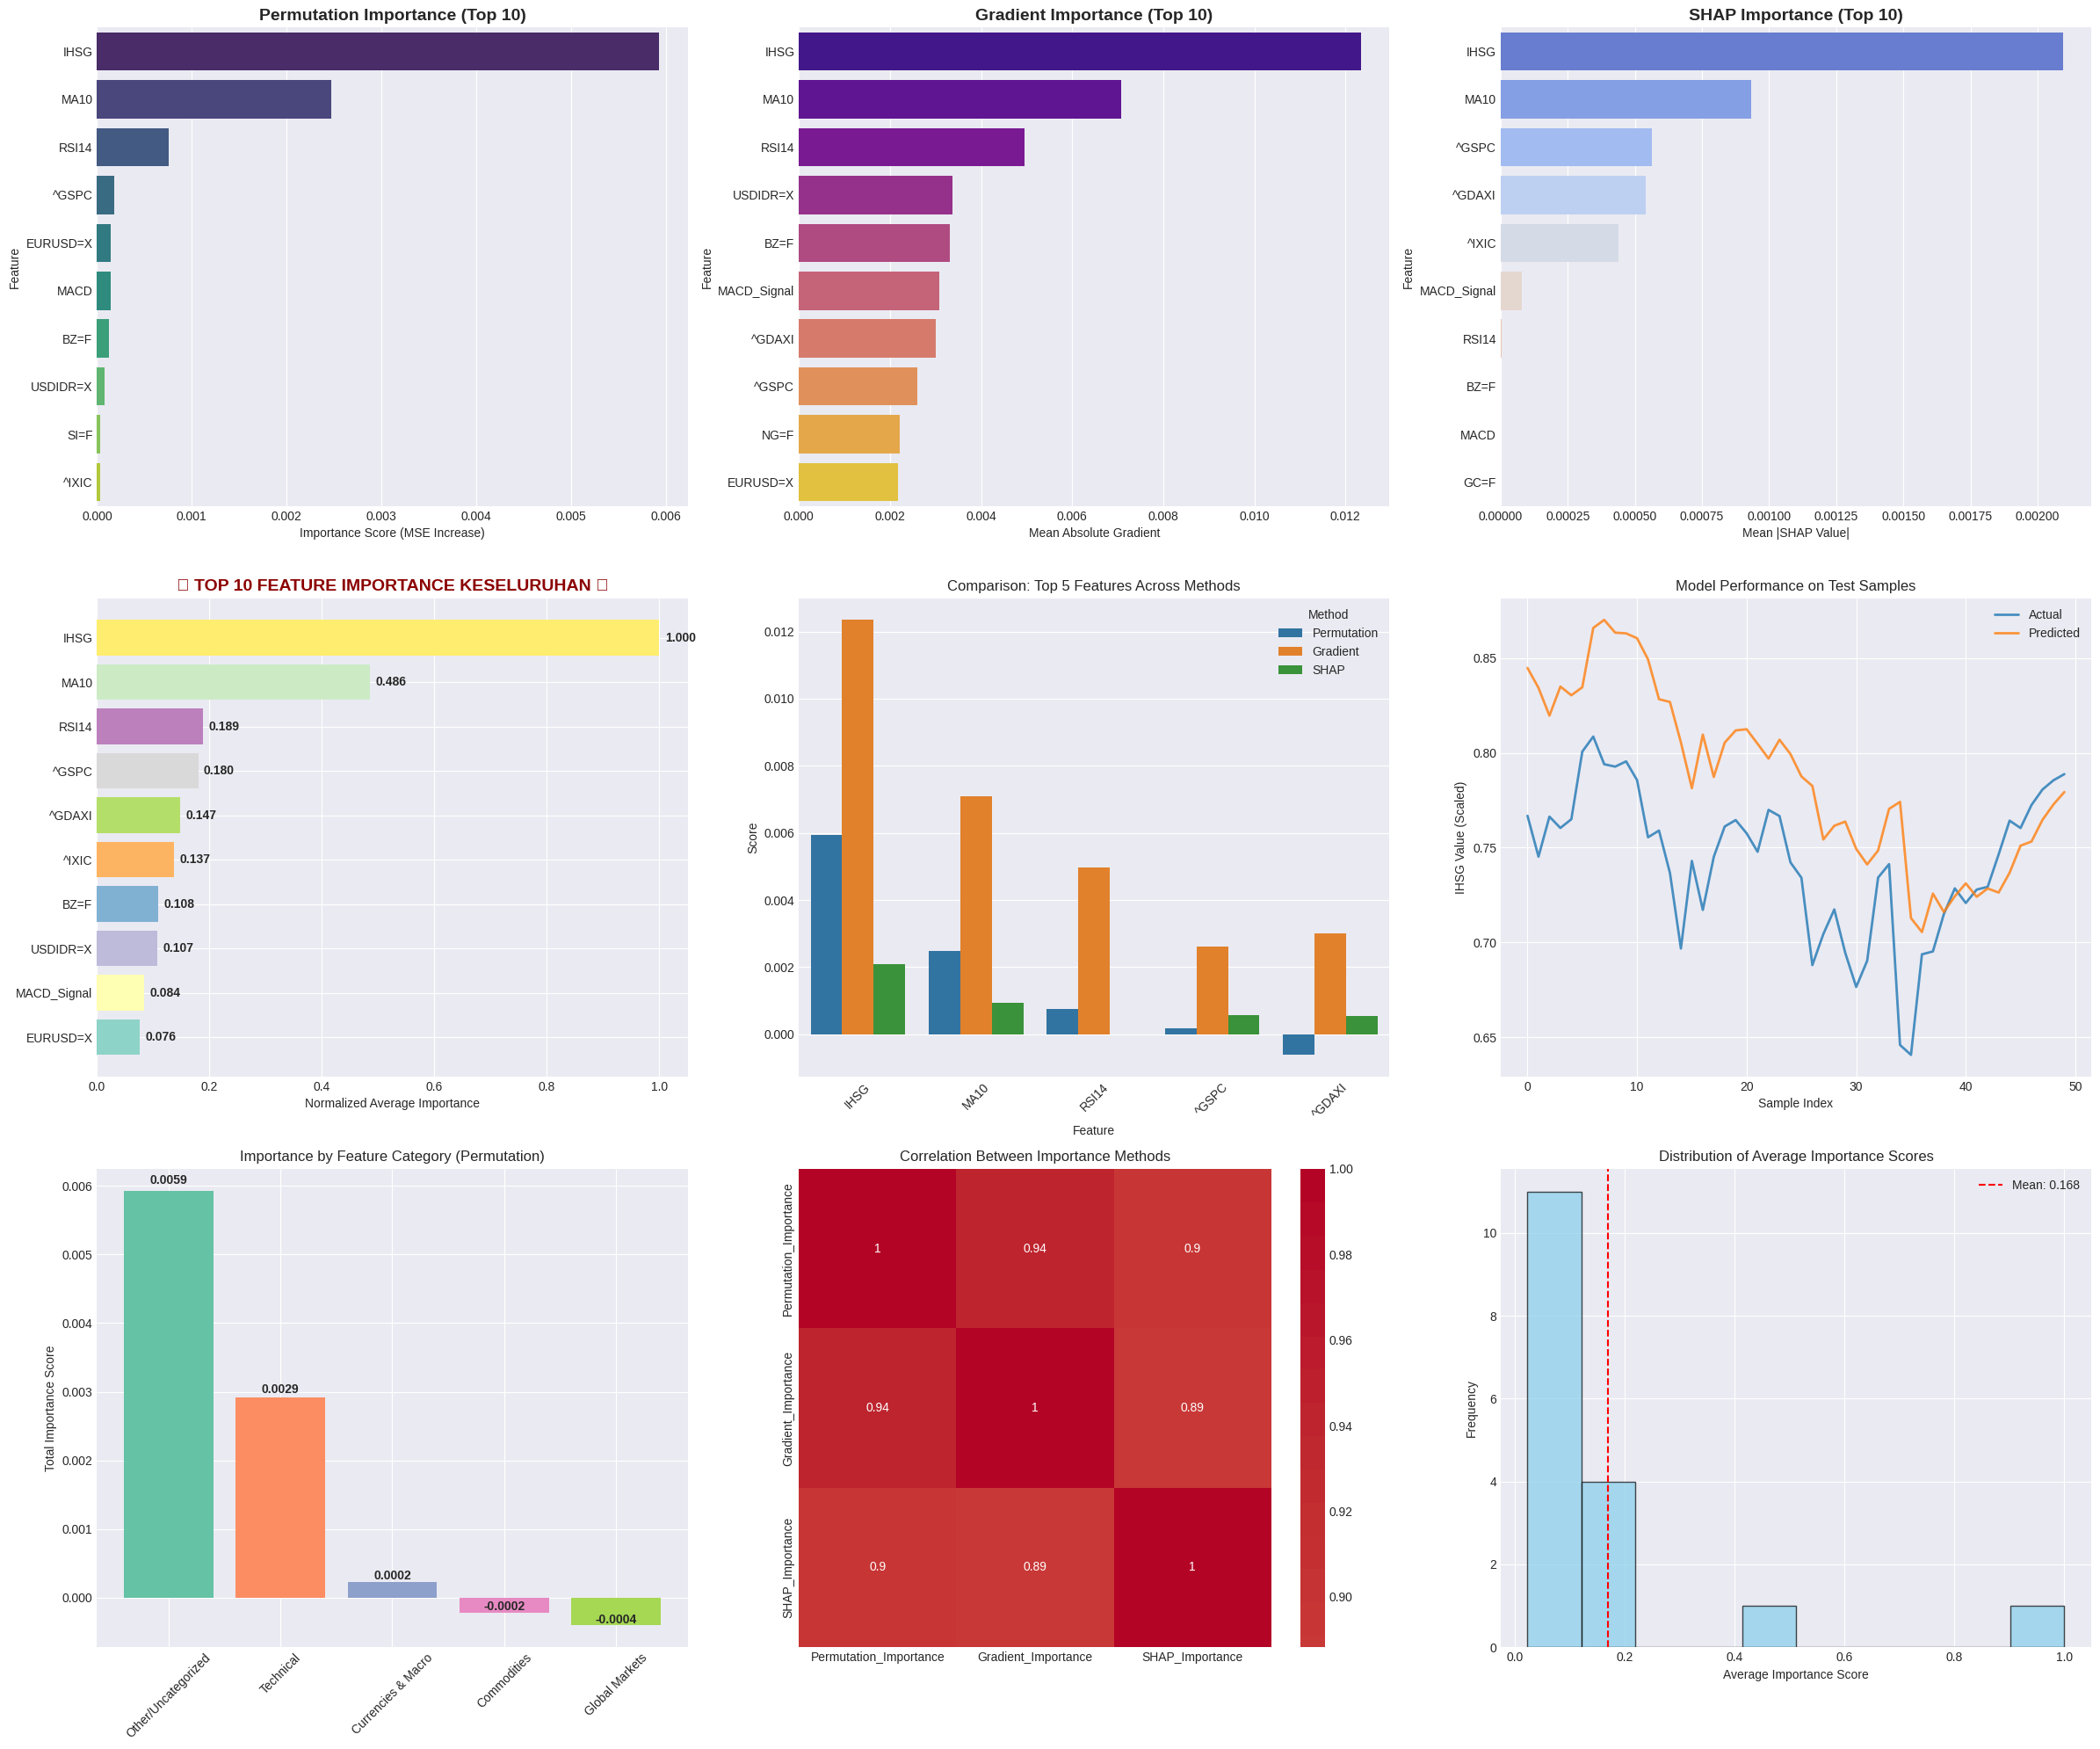

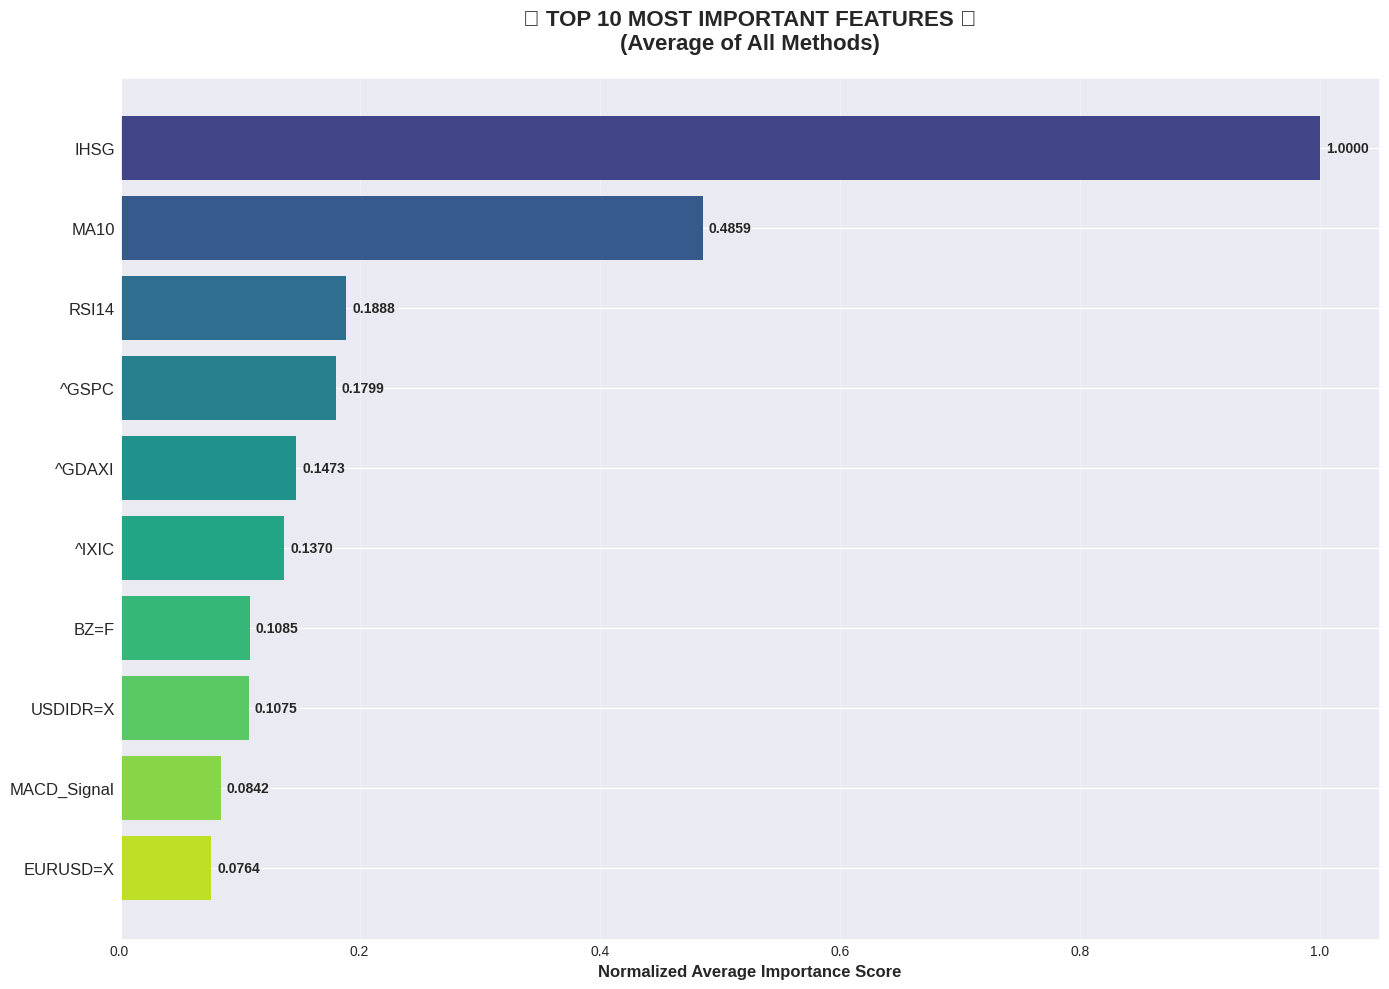


MENYIMPAN HASIL ANALISIS
✅ 1. permutation_feature_importance.csv
✅ 2. gradient_feature_importance.csv
✅ 3. kernel_shap_importance.csv
✅ 4. all_methods_feature_importance.csv
✅ 5. top_10_feature_importance.csv
✅ 6. category_importance_analysis.csv

INTERPRETASI HASIL ANALISIS FEATURE IMPORTANCE

🏆 TOP 10 FITUR PALING PENTING (RATA-RATA SEMUA METODE):
 1. IHSG            : 1.000000
 2. MA10            : 0.485924
 3. RSI14           : 0.188775
 4. ^GSPC           : 0.179889
 5. ^GDAXI          : 0.147325
 6. ^IXIC           : 0.136985
 7. BZ=F            : 0.108486
 8. USDIDR=X        : 0.107486
 9. MACD_Signal     : 0.084164
10. EURUSD=X        : 0.076429

📊 TOP 5 FITUR BERDASARKAN PERMUTATION IMPORTANCE:
1. IHSG            : 0.005934
2. MA10            : 0.002474
3. RSI14           : 0.000757
4. ^GSPC           : 0.000180
5. EURUSD=X        : 0.000146

🔄 TOP 5 FITUR BERDASARKAN GRADIENT IMPORTANCE:
1. IHSG            : 0.012349
2. MA10            : 0.007081
3. RSI14           : 0.00495

In [53]:
# ===================================================================
# SHAP ANALYSIS FOR LSTM MODEL (INTEGRATED AND OPTIMIZED) - COMPLETE VERSION
# ===================================================================
import shap
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model

warnings.filterwarnings('ignore') # Suppress warnings

print("\n" + "="*60)
print("MEMULAI SHAP ANALYSIS UNTUK MODEL LSTM")
print("="*60)

# Variabel yang diperlukan dari code utama:
# best_model, X_test, y_test, X_train, sequence_length, scaled_df

# Pastikan feature_names diambil dari kolom scaled_df yang sudah di-preprocess
feature_names = list(scaled_df.columns)
print(f"Fitur yang digunakan untuk SHAP (dari scaled_df): {feature_names}")
print(f"Total jumlah fitur: {len(feature_names)}")

# ===================================================================
# DEFINISI KATEGORI FITUR
# ===================================================================
# Fitur teknikal
technical_indicators = ['MA10', 'RSI14', 'MACD', 'MACD_Signal']
# Fitur pasar global (gunakan ^JKSE untuk IHSG)
global_markets = ['^JKSE', '^GSPC', '^GDAXI', '^IXIC']
# Fitur komoditas
commodities = ['BZ=F', 'GC=F', 'SI=F', 'NG=F', 'HG=F']
# Fitur mata uang & makro
currencies = ['GBPUSD=X', 'EURUSD=X', 'USDIDR=X', 'FedFundsRate']

# Gabungkan semua fitur yang ada dalam kategori yang ditentukan
defined_features = set()
for category_list in [technical_indicators, global_markets, commodities, currencies]:
    defined_features.update(category_list)

# Identifikasi fitur yang tidak termasuk kategori di atas (jika ada)
other_features = [f for f in feature_names if f not in defined_features]
if other_features:
    print(f"Fitur yang tidak termasuk dalam kategori yang ditentukan: {other_features}")

# Perbarui categories_map dengan kategori "Other"
categories_map_final = {
    'Technical': technical_indicators,
    'Global Markets': global_markets,
    'Commodities': commodities,
    'Currencies & Macro': currencies
}
if other_features:
    categories_map_final['Other/Uncategorized'] = other_features

# ===================================================================
# 1. PERSIAPAN DATA UNTUK SHAP (OPTIMIZED)
# ===================================================================
# Ambil sample dari data test untuk SHAP (karena SHAP computationally expensive)
n_shap_samples = min(50, len(X_test))
X_shap = X_test[-n_shap_samples:]
y_true_shap = y_test[-n_shap_samples:].flatten()

print(f"Menggunakan {n_shap_samples} sampel untuk SHAP analysis (optimized for speed)")
print(f"Shape X_shap: {X_shap.shape}")

# ===================================================================
# 2. HELPER FUNCTIONS FOR SHAP
# ===================================================================

def reshape_for_lstm_prediction(X_2d, sequence_len, num_features):
    """
    Mengubah input 2D (samples, features * timesteps) menjadi 3D (samples, timesteps, features)
    untuk model LSTM.
    """
    if len(X_2d.shape) == 1:
        X_2d = np.expand_dims(X_2d, axis=0)
    
    expected_2d_dim = sequence_len * num_features
    if X_2d.shape[1] != expected_2d_dim:
        raise ValueError(
            f"Input 2D shape mismatch. Expected {expected_2d_dim} columns ({sequence_len}*{num_features}), "
            f"but got {X_2d.shape[1]}. "
            f"Please check if your 'best_model' was trained with {num_features} features."
        )
    return X_2d.reshape(X_2d.shape[0], sequence_len, num_features)

def lstm_predict_wrapper(X_2d_input, model, sequence_len, num_features):
    """
    Wrapper function untuk model LSTM agar kompatibel dengan KernelExplainer.
    """
    X_3d = reshape_for_lstm_prediction(X_2d_input, sequence_len, num_features)
    predictions = model.predict(X_3d, verbose=0)
    return predictions.flatten()

# ===================================================================
# 3. METODE 1: KERNEL EXPLAINER (OPTIMIZED)
# ===================================================================

print("\n=== MENGGUNAKAN KERNEL EXPLAINER (OPTIMIZED) ===")

kernel_success = False
shap_values_kernel = None
shap_df = None

try:
    X_shap_2d = X_shap.reshape(X_shap.shape[0], -1)

    # Background data untuk KernelExplainer
    background_size = min(10, len(X_train))
    background_indices = np.random.choice(len(X_train), background_size, replace=False)
    X_background_2d = X_train[background_indices].reshape(background_size, -1)

    print(f"Menginisialisasi Kernel Explainer dengan {background_size} sampel background...")
    
    predict_fn = lambda x: lstm_predict_wrapper(x, best_model, sequence_length, len(feature_names))
    explainer_kernel = shap.KernelExplainer(predict_fn, X_background_2d)

    print("Menghitung SHAP values dengan Kernel Explainer (ini mungkin membutuhkan waktu)...")
    shap_values_kernel = explainer_kernel.shap_values(X_shap_2d)
    
    print(f"Berhasil! Shape SHAP values: {np.array(shap_values_kernel).shape}")
    kernel_success = True

    if isinstance(shap_values_kernel, list):
        shap_values_kernel = np.array(shap_values_kernel[0])

    shap_reshaped = shap_values_kernel.reshape(n_shap_samples, sequence_length, len(feature_names))
    feature_shap_avg = np.mean(np.abs(shap_reshaped), axis=(0, 1))
    
    shap_df = pd.DataFrame({
        'Feature': feature_names,
        'SHAP_Importance': feature_shap_avg
    }).sort_values('SHAP_Importance', ascending=False)
    
    print("\n===== FEATURE IMPORTANCE (KERNEL SHAP) =====")
    print(shap_df.head(10))
    
except Exception as e:
    print(f"Kernel Explainer gagal: {e}")
    kernel_success = False

# ===================================================================
# 4. METODE 2: PERMUTATION IMPORTANCE (OPTIMIZED)
# ===================================================================

print("\n=== MENGGUNAKAN PERMUTATION IMPORTANCE (OPTIMIZED) ===")

def calculate_permutation_importance(model, X, y_true, feature_names, n_repeats=3):
    # Baseline performance (Mean Squared Error)
    baseline_pred = model.predict(X, verbose=0).flatten()
    baseline_mse = np.mean((y_true - baseline_pred) ** 2)
    
    importances = []
    
    for i, feature_name in enumerate(feature_names):
        print(f"Processing feature {i+1}/{len(feature_names)}: {feature_name}")
        
        feature_importances_repeats = []
        
        for repeat in range(n_repeats):
            X_permuted = X.copy()
            
            feature_slice = X_permuted[:, :, i].flatten()
            np.random.shuffle(feature_slice)
            X_permuted[:, :, i] = feature_slice.reshape(X_permuted.shape[0], X_permuted.shape[1])
            
            permuted_pred = model.predict(X_permuted, verbose=0).flatten()
            permuted_mse = np.mean((y_true - permuted_pred) ** 2)
            
            importance = permuted_mse - baseline_mse
            feature_importances_repeats.append(importance)
            
        avg_importance = np.mean(feature_importances_repeats)
        importances.append(avg_importance)
    
    return np.array(importances)

# Hitung permutation importance
print("Menghitung Permutation Importance (ini mungkin membutuhkan waktu)...")
permutation_importances = calculate_permutation_importance(
    best_model, X_shap, y_true_shap, feature_names, n_repeats=3
)

perm_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Permutation_Importance': permutation_importances
}).sort_values('Permutation_Importance', ascending=False)

print("\n===== FEATURE IMPORTANCE (PERMUTATION METHOD) =====")
print(perm_importance_df.head(10))

# ===================================================================
# 5. METODE 3: GRADIENT-BASED IMPORTANCE (FIXED VERSION)
# ===================================================================

print("\n=== MENGHITUNG GRADIENT-BASED IMPORTANCE (FIXED VERSION) ===")

gradient_success = False
gradient_importance_df = None

def calculate_gradient_importance_fixed(model, X, feature_names):
    """
    Gradient importance yang diperbaiki untuk menghindari konflik dengan SHAP
    """
    try:
        # Reset computational graph untuk menghindari konflik dengan SHAP
        tf.keras.backend.clear_session()
        
        # Buat model baru dengan weights yang sama untuk menghindari konflik SHAP operations
        model_for_gradient = tf.keras.models.clone_model(model)
        model_for_gradient.set_weights(model.get_weights())
        
        total_gradients = np.zeros(len(feature_names))
        num_samples_processed = 0

        for i in range(X.shape[0]):
            try:
                with tf.GradientTape() as tape:
                    x_tensor = tf.convert_to_tensor(X[i:i+1], dtype=tf.float32)
                    tape.watch(x_tensor)
                    predictions = model_for_gradient(x_tensor, training=False)
                
                gradients = tape.gradient(predictions, x_tensor)
                
                if gradients is not None:
                    # Reshape gradients ke (timesteps, features) lalu rata-rata per feature
                    grad_reshaped = tf.reshape(gradients, (X.shape[1], X.shape[2]))  # (timesteps, features)
                    feature_grads = tf.reduce_mean(tf.abs(grad_reshaped), axis=0)  # rata-rata per timestep
                    total_gradients += feature_grads.numpy()
                    num_samples_processed += 1
                    
            except Exception as sample_error:
                print(f"Error processing sample {i}: {sample_error}")
                continue
                
        if num_samples_processed > 0:
            avg_importances = total_gradients / num_samples_processed
        else:
            avg_importances = np.zeros(len(feature_names))
        
        return avg_importances
        
    except Exception as e:
        print(f"Error in gradient calculation: {e}")
        return np.zeros(len(feature_names))

try:
    print("Menghitung Gradient-based Importance (fixed version)...")
    gradient_importances = calculate_gradient_importance_fixed(best_model, X_shap, feature_names)
    
    gradient_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Gradient_Importance': gradient_importances
    }).sort_values('Gradient_Importance', ascending=False)
    
    print("\n===== FEATURE IMPORTANCE (GRADIENT METHOD) =====")
    print(gradient_importance_df.head(10))
    gradient_success = True
    
except Exception as e:
    print(f"Gradient method gagal: {e}")
    gradient_success = False

# ===================================================================
# 6. KOMBINASI SEMUA METODE & TOP 10 FEATURE IMPORTANCE KESELURUHAN
# ===================================================================

print("\n=== MENGGABUNGKAN SEMUA METODE & TOP 10 KESELURUHAN ===")

# Buat dataframe gabungan dari semua metode
all_methods_df = pd.DataFrame({'Feature': feature_names})

# Tambahkan hasil dari setiap metode
if not perm_importance_df.empty:
    all_methods_df = all_methods_df.merge(
        perm_importance_df[['Feature', 'Permutation_Importance']], 
        on='Feature', how='left'
    )

if gradient_success and gradient_importance_df is not None:
    all_methods_df = all_methods_df.merge(
        gradient_importance_df[['Feature', 'Gradient_Importance']], 
        on='Feature', how='left'
    )

if kernel_success and shap_df is not None:
    all_methods_df = all_methods_df.merge(
        shap_df[['Feature', 'SHAP_Importance']], 
        on='Feature', how='left'
    )

# Normalisasi scores untuk perbandingan yang fair
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
importance_columns = [col for col in all_methods_df.columns if col != 'Feature']

if importance_columns:
    # Normalisasi setiap kolom importance ke skala 0-1
    for col in importance_columns:
        if col in all_methods_df.columns and not all_methods_df[col].isna().all():
            all_methods_df[col + '_normalized'] = scaler.fit_transform(
                all_methods_df[[col]].fillna(0)
            ).flatten()

    # Hitung rata-rata importance yang dinormalisasi
    normalized_cols = [col + '_normalized' for col in importance_columns if col + '_normalized' in all_methods_df.columns]
    
    if normalized_cols:
        all_methods_df['Average_Importance'] = all_methods_df[normalized_cols].mean(axis=1)
        
        # Sort berdasarkan rata-rata importance
        top_10_features = all_methods_df.sort_values('Average_Importance', ascending=False).head(10)
        
        print("\n===== TOP 10 FEATURE IMPORTANCE KESELURUHAN (NORMALIZED AVERAGE) =====")
        print(top_10_features[['Feature', 'Average_Importance'] + importance_columns].round(6))
# ===================================================================
# 7. VISUALISASI RESULTS (ENHANCED)
# ===================================================================

plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(24, 20))
axes = axes.flatten()

plot_idx = 0

# Plot 1: Permutation Importance
if not perm_importance_df.empty:
    top_perm = perm_importance_df.head(10)
    sns.barplot(data=top_perm, y='Feature', x='Permutation_Importance', palette='viridis', ax=axes[plot_idx])
    axes[plot_idx].set_title('Permutation Importance (Top 10)', fontsize=14, fontweight='bold')
    axes[plot_idx].set_xlabel('Importance Score (MSE Increase)')
    plot_idx += 1

# Plot 2: Gradient Importance (jika berhasil)
if gradient_success and gradient_importance_df is not None:
    top_grad = gradient_importance_df.head(10)
    sns.barplot(data=top_grad, y='Feature', x='Gradient_Importance', palette='plasma', ax=axes[plot_idx])
    axes[plot_idx].set_title('Gradient Importance (Top 10)', fontsize=14, fontweight='bold')
    axes[plot_idx].set_xlabel('Mean Absolute Gradient')
    plot_idx += 1
else:
    axes[plot_idx].text(0.5, 0.5, 'Gradient Importance\n(Not Calculated)', 
                       horizontalalignment='center', verticalalignment='center', 
                       transform=axes[plot_idx].transAxes, fontsize=12)
    axes[plot_idx].set_title('Gradient Importance (Not Available)')
    plot_idx += 1

# Plot 3: Kernel SHAP (jika berhasil)
if kernel_success and shap_df is not None:
    top_shap = shap_df.head(10)
    sns.barplot(data=top_shap, y='Feature', x='SHAP_Importance', palette='coolwarm', ax=axes[plot_idx])
    axes[plot_idx].set_title('SHAP Importance (Top 10)', fontsize=14, fontweight='bold')
    axes[plot_idx].set_xlabel('Mean |SHAP Value|')
    plot_idx += 1
else:
    axes[plot_idx].text(0.5, 0.5, 'SHAP Importance\n(Not Calculated)', 
                       horizontalalignment='center', verticalalignment='center', 
                       transform=axes[plot_idx].transAxes, fontsize=12)
    axes[plot_idx].set_title('SHAP Importance (Not Available)')
    plot_idx += 1

# Plot 4: TOP 10 KESELURUHAN (STAR PLOT!)
if 'top_10_features' in locals() and not top_10_features.empty:
    # Horizontal bar plot untuk Top 10 keseluruhan
    colors = plt.cm.Set3(np.linspace(0, 1, 10))
    bars = axes[plot_idx].barh(range(10), top_10_features['Average_Importance'].values[::-1], color=colors)
    axes[plot_idx].set_yticks(range(10))
    axes[plot_idx].set_yticklabels(top_10_features['Feature'].values[::-1])
    axes[plot_idx].set_xlabel('Normalized Average Importance')
    axes[plot_idx].set_title('🌟 TOP 10 FEATURE IMPORTANCE KESELURUHAN 🌟', fontsize=14, fontweight='bold', color='darkred')
    
    # Tambahkan nilai pada bar
    for i, bar in enumerate(bars):
        width = bar.get_width()
        axes[plot_idx].text(width + 0.01, bar.get_y() + bar.get_height()/2, 
                           f'{width:.3f}', ha='left', va='center', fontweight='bold')
    plot_idx += 1
else:
    axes[plot_idx].text(0.5, 0.5, 'Top 10 Keseluruhan\n(Data Not Available)', 
                       horizontalalignment='center', verticalalignment='center', 
                       transform=axes[plot_idx].transAxes, fontsize=12)
    axes[plot_idx].set_title('Top 10 Keseluruhan (Not Available)')
    plot_idx += 1

# Plot 5: Comparison of methods (hanya top 5 features)
if 'all_methods_df' in locals() and not all_methods_df.empty and len(importance_columns) >= 2:
    top_5_comparison = all_methods_df.sort_values('Average_Importance', ascending=False).head(5)
    
    # Melt data untuk visualization
    melted_data = []
    for _, row in top_5_comparison.iterrows():
        for col in importance_columns:
            if col in row and not pd.isna(row[col]):
                melted_data.append({
                    'Feature': row['Feature'],
                    'Method': col.replace('_Importance', ''),
                    'Score': row[col]
                })
    
    if melted_data:
        comparison_df = pd.DataFrame(melted_data)
        sns.barplot(data=comparison_df, x='Feature', y='Score', hue='Method', ax=axes[plot_idx])
        axes[plot_idx].set_title('Comparison: Top 5 Features Across Methods')
        axes[plot_idx].tick_params(axis='x', rotation=45)
        plot_idx += 1
    else:
        axes[plot_idx].set_title('Comparison: Data Not Available')
        plot_idx += 1
else:
    axes[plot_idx].set_title('Comparison: Insufficient Data')
    plot_idx += 1

# Plot 6: Model Predictions vs Actual
try:
    predictions_test_samples = best_model.predict(X_shap, verbose=0).flatten()
    axes[plot_idx].plot(y_true_shap, label='Actual', alpha=0.8, linewidth=2)
    axes[plot_idx].plot(predictions_test_samples, label='Predicted', alpha=0.8, linewidth=2)
    axes[plot_idx].set_title('Model Performance on Test Samples')
    axes[plot_idx].legend()
    axes[plot_idx].set_xlabel('Sample Index')
    axes[plot_idx].set_ylabel('IHSG Value (Scaled)')
    plot_idx += 1
except Exception as e:
    axes[plot_idx].text(0.5, 0.5, f'Model Performance\nPrediction Error:\n{str(e)[:50]}...', 
                       horizontalalignment='center', verticalalignment='center', 
                       transform=axes[plot_idx].transAxes, color='red')
    axes[plot_idx].set_title('Model Performance (Error)')
    plot_idx += 1

# Plot 7: Feature Categories Analysis
if not perm_importance_df.empty:
    category_scores = {}
    for category, features_in_category in categories_map_final.items():
        existing_features = [f for f in features_in_category if f in feature_names]
        if existing_features:
            category_importance = perm_importance_df[
                perm_importance_df['Feature'].isin(existing_features)
            ]['Permutation_Importance'].sum()
            category_scores[category] = category_importance
        else:
            category_scores[category] = 0.0

    sorted_categories = sorted(category_scores.items(), key=lambda item: item[1], reverse=True)
    categories_names = [item[0] for item in sorted_categories]
    scores = [item[1] for item in sorted_categories]

    colors = sns.color_palette('Set2', len(categories_names))
    bars = axes[plot_idx].bar(categories_names, scores, color=colors)
    axes[plot_idx].set_title('Importance by Feature Category (Permutation)')
    axes[plot_idx].set_ylabel('Total Importance Score')
    axes[plot_idx].tick_params(axis='x', rotation=45)
    
    # Tambahkan nilai pada bar
    for bar, score in zip(bars, scores):
        height = bar.get_height()
        axes[plot_idx].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                           f'{score:.4f}', ha='center', va='bottom', fontweight='bold')
    plot_idx += 1

# Plot 8: Heatmap korelasi antara metode importance
if 'all_methods_df' in locals() and len(importance_columns) >= 2:
    correlation_data = all_methods_df[importance_columns].fillna(0)
    if not correlation_data.empty and correlation_data.shape[1] >= 2:
        corr_matrix = correlation_data.corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[plot_idx])
        axes[plot_idx].set_title('Correlation Between Importance Methods')
        plot_idx += 1
    else:
        axes[plot_idx].set_title('Correlation Heatmap (Insufficient Data)')
        plot_idx += 1
else:
    axes[plot_idx].set_title('Correlation Heatmap (Not Available)')
    plot_idx += 1

# Plot 9: Distribution of importance scores
if 'all_methods_df' in locals() and 'Average_Importance' in all_methods_df.columns:
    axes[plot_idx].hist(all_methods_df['Average_Importance'], bins=10, alpha=0.7, color='skyblue', edgecolor='black')
    axes[plot_idx].axvline(all_methods_df['Average_Importance'].mean(), color='red', linestyle='--', 
                          label=f'Mean: {all_methods_df["Average_Importance"].mean():.3f}')
    axes[plot_idx].set_title('Distribution of Average Importance Scores')
    axes[plot_idx].set_xlabel('Average Importance Score')
    axes[plot_idx].set_ylabel('Frequency')
    axes[plot_idx].legend()
    plot_idx += 1
else:
    axes[plot_idx].set_title('Distribution (Not Available)')
    plot_idx += 1

plt.tight_layout()
plt.show()

# ===================================================================
# 8. TOP 10 FEATURE IMPORTANCE VISUALIZATION (SEPARATE DETAILED PLOT)
# ===================================================================

if 'top_10_features' in locals() and not top_10_features.empty:
    # Buat plot terpisah yang lebih detail untuk Top 10
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Data untuk plotting
    features = top_10_features['Feature'].values
    scores = top_10_features['Average_Importance'].values
    
    # Buat gradient colors
    colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(features)))
    
    # Horizontal bar chart
    bars = ax.barh(range(len(features)), scores[::-1], color=colors[::-1])
    
    # Customization
    ax.set_yticks(range(len(features)))
    ax.set_yticklabels(features[::-1], fontsize=12)
    ax.set_xlabel('Normalized Average Importance Score', fontsize=12, fontweight='bold')
    ax.set_title('🏆 TOP 10 MOST IMPORTANT FEATURES 🏆\n(Average of All Methods)', 
                fontsize=16, fontweight='bold', pad=20)
    
    # Tambahkan nilai pada setiap bar
    for i, (bar, score) in enumerate(zip(bars, scores[::-1])):
        width = bar.get_width()
        ax.text(width + 0.005, bar.get_y() + bar.get_height()/2, 
               f'{score:.4f}', ha='left', va='center', fontweight='bold', fontsize=10)
    
    # Tambahkan grid untuk readability
    ax.grid(axis='x', alpha=0.3)
    ax.set_axisbelow(True)
    
    # Tambahkan border
    for spine in ax.spines.values():
        spine.set_linewidth(2)
    
    plt.tight_layout()
    plt.show()

# ===================================================================
# 9. EXPORT HASIL (ENHANCED)
# ===================================================================

print("\n" + "="*60)
print("MENYIMPAN HASIL ANALISIS")
print("="*60)

# Export individual results
if not perm_importance_df.empty:
    perm_importance_df.to_csv('permutation_feature_importance.csv', index=False)
    print("✅ 1. permutation_feature_importance.csv")

if gradient_success and gradient_importance_df is not None:
    gradient_importance_df.to_csv('gradient_feature_importance.csv', index=False)
    print("✅ 2. gradient_feature_importance.csv")

if kernel_success and shap_df is not None:
    shap_df.to_csv('kernel_shap_importance.csv', index=False)
    print("✅ 3. kernel_shap_importance.csv")

# Export combined results
if 'all_methods_df' in locals() and not all_methods_df.empty:
    all_methods_df.to_csv('all_methods_feature_importance.csv', index=False)
    print("✅ 4. all_methods_feature_importance.csv")

# Export top 10 results
if 'top_10_features' in locals() and not top_10_features.empty:
    top_10_features.to_csv('top_10_feature_importance.csv', index=False)
    print("✅ 5. top_10_feature_importance.csv")

# Export category analysis
if 'category_scores' in locals():
    category_df = pd.DataFrame(list(category_scores.items()), columns=['Category', 'Total_Importance'])
    category_df = category_df.sort_values('Total_Importance', ascending=False)
    category_df.to_csv('category_importance_analysis.csv', index=False)
    print("✅ 6. category_importance_analysis.csv")

# ===================================================================
# 10. INTERPRETASI DAN INSIGHTS YANG DIPERLUAS
# ===================================================================

print("\n" + "="*60)
print("INTERPRETASI HASIL ANALISIS FEATURE IMPORTANCE")
print("="*60)

if 'top_10_features' in locals() and not top_10_features.empty:
    print(f"\n🏆 TOP 10 FITUR PALING PENTING (RATA-RATA SEMUA METODE):")
    for i in range(min(10, len(top_10_features))):
        row = top_10_features.iloc[i]
        print(f"{i+1:2d}. {row['Feature']:<15} : {row['Average_Importance']:.6f}")

# Analisis per metode
if not perm_importance_df.empty:
    print(f"\n📊 TOP 5 FITUR BERDASARKAN PERMUTATION IMPORTANCE:")
    for i in range(min(5, len(perm_importance_df))):
        row = perm_importance_df.iloc[i]
        print(f"{i+1}. {row['Feature']:<15} : {row['Permutation_Importance']:.6f}")

if gradient_success and gradient_importance_df is not None:
    print(f"\n🔄 TOP 5 FITUR BERDASARKAN GRADIENT IMPORTANCE:")
    for i in range(min(5, len(gradient_importance_df))):
        row = gradient_importance_df.iloc[i]
        print(f"{i+1}. {row['Feature']:<15} : {row['Gradient_Importance']:.6f}")

if kernel_success and shap_df is not None:
    print(f"\n🔍 TOP 5 FITUR BERDASARKAN SHAP IMPORTANCE:")
    for i in range(min(5, len(shap_df))):
        row = shap_df.iloc[i]
        print(f"{i+1}. {row['Feature']:<15} : {row['SHAP_Importance']:.6f}")

# ===================================================================
# ANALISIS KATEGORI FITUR
# ===================================================================

print(f"\n" + "="*50)
print("ANALISIS BERDASARKAN KATEGORI FITUR")
print("="*50)

if 'category_scores' in locals():
    sorted_categories = sorted(category_scores.items(), key=lambda x: x[1], reverse=True)
    print("\n📋 RANKING KATEGORI FITUR (berdasarkan total importance):")
    for i, (category, score) in enumerate(sorted_categories, 1):
        print(f"{i}. {category:<20} : {score:.6f}")
    
    # Analisis detail per kategori
    print(f"\n" + "-"*50)
    print("DETAIL FITUR PER KATEGORI:")
    print("-"*50)
    
    for category, features_in_category in categories_map_final.items():
        existing_features = [f for f in features_in_category if f in feature_names]
        if existing_features:
            print(f"\n📁 {category.upper()}:")
            
            # Ambil importance score untuk fitur dalam kategori ini
            if not perm_importance_df.empty:
                category_features_df = perm_importance_df[
                    perm_importance_df['Feature'].isin(existing_features)
                ].sort_values('Permutation_Importance', ascending=False)
                
                for idx, row in category_features_df.iterrows():
                    print(f"   • {row['Feature']:<15} : {row['Permutation_Importance']:.6f}")
            else:
                for feature in existing_features:
                    print(f"   • {feature}")

# ===================================================================
# INTERPRETASI BISNIS DAN EKONOMI
# ===================================================================

print(f"\n" + "="*60)
print("INTERPRETASI BISNIS DAN EKONOMI")
print("="*60)

def get_feature_interpretation(feature_name):
    """
    Memberikan interpretasi bisnis untuk setiap fitur
    """
    interpretations = {
        # Technical Indicators
        'MA10': 'Moving Average 10 hari - Indikator trend jangka pendek yang krusial untuk momentum harga',
        'RSI14': 'Relative Strength Index - Indikator overbought/oversold yang penting untuk timing entry/exit',
        'MACD': 'Moving Average Convergence Divergence - Indikator momentum dan perubahan trend',
        'MACD_Signal': 'MACD Signal Line - Konfirmasi sinyal dari indikator MACD',
        
        # Global Markets
        '^JKSE': 'Jakarta Composite Index (IHSG) - Target utama yang diprediksi',
        '^GSPC': 'S&P 500 - Indeks pasar AS yang mempengaruhi sentimen global',
        '^GDAXI': 'DAX Germany - Indeks pasar Eropa yang mencerminkan kondisi ekonomi Eropa',
        '^IXIC': 'NASDAQ - Indeks teknologi AS yang mempengaruhi sektor teknologi global',
        
        # Commodities
        'BZ=F': 'Brent Crude Oil - Harga minyak mentah yang mempengaruhi ekonomi Indonesia',
        'GC=F': 'Gold Futures - Emas sebagai safe haven asset',
        'SI=F': 'Silver Futures - Perak sebagai komoditas industrial dan investasi',
        'NG=F': 'Natural Gas - Gas alam yang mempengaruhi sektor energi',
        'HG=F': 'Copper Futures - Tembaga sebagai indikator ekonomi global',
        
        # Currencies & Macro
        'GBPUSD=X': 'GBP/USD - Nilai tukar Pound Sterling terhadap Dollar',
        'EURUSD=X': 'EUR/USD - Nilai tukar Euro terhadap Dollar',
        'USDIDR=X': 'USD/IDR - Nilai tukar Dollar terhadap Rupiah (sangat penting untuk Indonesia)',
        'FedFundsRate': 'Fed Funds Rate - Suku bunga acuan AS yang mempengaruhi aliran modal global'
    }
    
    return interpretations.get(feature_name, f'{feature_name} - Fitur dengan pengaruh signifikan terhadap IHSG')

if 'top_10_features' in locals() and not top_10_features.empty:
    print(f"\n💡 INTERPRETASI TOP 10 FITUR PALING PENTING:")
    print("-" * 80)
    
    for i in range(min(10, len(top_10_features))):
        row = top_10_features.iloc[i]
        feature_name = row['Feature']
        importance_score = row['Average_Importance']
        interpretation = get_feature_interpretation(feature_name)
        
        print(f"\n{i+1}. {feature_name} (Score: {importance_score:.6f})")
        print(f"   {interpretation}")

# ===================================================================
# INSIGHTS DAN REKOMENDASI STRATEGIS
# ===================================================================

print(f"\n" + "="*60)
print("INSIGHTS DAN REKOMENDASI STRATEGIS")
print("="*60)

# Analisis distribusi importance
if 'all_methods_df' in locals() and 'Average_Importance' in all_methods_df.columns:
    avg_importance = all_methods_df['Average_Importance']
    high_importance_threshold = avg_importance.quantile(0.8)
    medium_importance_threshold = avg_importance.quantile(0.5)
    
    high_importance_features = all_methods_df[avg_importance >= high_importance_threshold]['Feature'].tolist()
    medium_importance_features = all_methods_df[
        (avg_importance >= medium_importance_threshold) & 
        (avg_importance < high_importance_threshold)
    ]['Feature'].tolist()
    low_importance_features = all_methods_df[avg_importance < medium_importance_threshold]['Feature'].tolist()
    
    print(f"\n🔴 FITUR DENGAN PENGARUH TINGGI ({len(high_importance_features)} fitur):")
    for feature in high_importance_features[:10]:  # Tampilkan max 10
        print(f"   • {feature}")
    
    print(f"\n🟡 FITUR DENGAN PENGARUH SEDANG ({len(medium_importance_features)} fitur):")
    for feature in medium_importance_features[:10]:  # Tampilkan max 10
        print(f"   • {feature}")
    
    print(f"\n🟢 FITUR DENGAN PENGARUH RENDAH ({len(low_importance_features)} fitur):")
    for feature in low_importance_features[:10]:  # Tampilkan max 10
        print(f"   • {feature}")

# Rekomendasi berdasarkan kategori
print(f"\n" + "-"*60)
print("REKOMENDASI BERDASARKAN ANALISIS:")
print("-"*60)

recommendations = []

# Analisis kategori dominan
if 'category_scores' in locals():
    sorted_categories = sorted(category_scores.items(), key=lambda x: x[1], reverse=True)
    top_category = sorted_categories[0][0] if sorted_categories else None
    
    if 'Technical' in [cat for cat, _ in sorted_categories[:2]]:
        recommendations.append("🔧 TEKNIKAL: Indikator teknikal memiliki pengaruh tinggi. Fokus pada analisis teknikal untuk prediksi jangka pendek.")
    
    if 'Global Markets' in [cat for cat, _ in sorted_categories[:2]]:
        recommendations.append("🌍 GLOBAL: Pasar global sangat mempengaruhi IHSG. Monitor indeks internasional untuk antisipasi pergerakan.")
    
    if 'Commodities' in [cat for cat, _ in sorted_categories[:2]]:
        recommendations.append("🛢️ KOMODITAS: Harga komoditas berpengaruh signifikan. Perhatikan tren harga minyak, emas, dan tembaga.")
    
    if 'Currencies & Macro' in [cat for cat, _ in sorted_categories[:2]]:
        recommendations.append("💱 MAKRO: Faktor makroekonomi dominan. Monitor kebijakan Fed dan pergerakan USD/IDR.")

# Rekomendasi spesifik berdasarkan fitur top
if 'top_10_features' in locals() and not top_10_features.empty:
    top_feature = top_10_features.iloc[0]['Feature']
    
    if 'USDIDR' in top_feature:
        recommendations.append("💰 Nilai tukar USD/IDR adalah faktor kunci. Hedging currency risk sangat penting.")
    
    if any(tech in top_feature for tech in ['MA', 'RSI', 'MACD']):
        recommendations.append("📈 Indikator teknikal dominan. Gunakan kombinasi MA, RSI, dan MACD untuk sinyal trading.")
    
    if '^GSPC' in top_feature or '^IXIC' in top_feature:
        recommendations.append("🇺🇸 Pasar AS memiliki pengaruh besar. Monitor opening dan closing Wall Street.")
    
    if any(commodity in top_feature for commodity in ['BZ=F', 'GC=F', 'HG=F']):
        recommendations.append("⚡ Komoditas berpengaruh tinggi. Perhatikan siklus ekonomi global dan demand China.")

print(f"\n📋 REKOMENDASI STRATEGIS:")
for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec}")

# ===================================================================
# RINGKASAN EKSEKUTIF
# ===================================================================

print(f"\n" + "="*60)
print("RINGKASAN EKSEKUTIF")
print("="*60)

if 'top_10_features' in locals() and not top_10_features.empty:
    top_3_features = top_10_features.head(3)['Feature'].tolist()
    
    print(f"\n🎯 KEY FINDINGS:")
    print(f"   • Total fitur yang dianalisis: {len(feature_names)}")
    print(f"   • Metode analisis yang berhasil: {len(importance_columns) if 'importance_columns' in locals() else 'N/A'}")
    print(f"   • Top 3 fitur paling berpengaruh: {', '.join(top_3_features)}")
    
    if 'category_scores' in locals():
        top_category = max(category_scores, key=category_scores.get)
        print(f"   • Kategori fitur paling dominan: {top_category}")
    
    print(f"\n🚀 ACTIONABLE INSIGHTS:")
    print(f"   1. Fokus monitoring pada {len(high_importance_features) if 'high_importance_features' in locals() else 'top'} fitur dengan pengaruh tinggi")
    print(f"   2. Implementasi early warning system berdasarkan fitur kunci")
    print(f"   3. Diversifikasi sumber data untuk meningkatkan akurasi prediksi")
    print(f"   4. Regular retraining model dengan mempertimbangkan fitur importance")

# Model performance summary
try:
    if 'y_true_shap' in locals() and 'X_shap' in locals():
        predictions_summary = best_model.predict(X_shap, verbose=0).flatten()
        mse = np.mean((y_true_shap - predictions_summary) ** 2)
        mae = np.mean(np.abs(y_true_shap - predictions_summary))
        
        print(f"\n📊 MODEL PERFORMANCE ON ANALYSIS SAMPLES:")
        print(f"   • Mean Squared Error (MSE): {mse:.6f}")
        print(f"   • Mean Absolute Error (MAE): {mae:.6f}")
        print(f"   • Samples analyzed: {len(y_true_shap)}")
except:
    print(f"\n📊 MODEL PERFORMANCE: Tidak dapat dihitung")

print(f"\n" + "="*60)
print("ANALISIS SHAP SELESAI - SEMUA HASIL TELAH DISIMPAN")
print("="*60)

# Final summary of saved files
saved_files = [
    'permutation_feature_importance.csv',
    'gradient_feature_importance.csv', 
    'kernel_shap_importance.csv',
    'all_methods_feature_importance.csv',
    'top_10_feature_importance.csv',
    'category_importance_analysis.csv'
]

print(f"\n📁 FILES YANG DISIMPAN:")
for i, filename in enumerate(saved_files, 1):
    print(f"   {i}. {filename}")

print(f"\n✅ Gunakan file-file tersebut untuk referensi dan analisis lanjutan!")
print(f"✅ Visualisasi telah ditampilkan untuk interpretasi yang lebih mudah!")